In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#import stuff from the mixture_composition_regression package
from mixture_composition_regression.examples.load_dipa_water_nacl_training_set import load_training_set
from mixture_composition_regression.cross_validation import cv_on_model_and_wavelength
from mixture_composition_regression.import_spectrum import clean_data
from mixture_composition_regression.sample import Sample
from mixture_composition_regression.mixture import Mixture
from mixture_composition_regression.preprocessor_pipeline import get_Xy
from mixture_composition_regression.gridsearch_dataset import grid_search_dataset

# import needed packages from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
import os

In [10]:
# set the current working directory
dir = '/Users/ianbillinge/dev/mixture_composition_regression/mixture_composition_regression/examples/cellulose_example/expanded_training_set/lignocellulose_expanded_training_set'

# read and clean the training spectra
file = os.path.join(os.sep, dir, 'all_spectra.csv')
df = clean_data(file)

# read and clean target data (weight fraction).
w_file = os.path.join(os.sep, dir, 'composition.csv')
composition = pd.read_csv(w_file)

# get a list of sample names
samples = np.array(composition.columns)[1:]

cp = {'name': ['cellulose', 'hemicellulose', 'lignin', 'rot'],
      'mw': [1, 1, 1, 1],
      'nu': [1, 1, 1, 1]}

# create a list of Sample objects (one for each spectrum you collected)
ds = []
for s in samples:
    ds.append(Sample(s, df, x_col_name='wavenumber', a_col_name=s, 
                     chem_properties=cp, w=list(composition[s]/100.),
                    xbounds = [500, 3900]))

# create a mixture_composition_regression.Mixture object
# NOTE: I will probably remove the Mixture object from the package in the future, 
# and I do the regression without using the Mixture, but there are some plotting things that are quite nice.
mix = Mixture(ds)

Weights do not sum to 1 in sample CF1-1
Weights do not sum to 1 in sample CF1-2
Weights do not sum to 1 in sample CF1-3
Weights do not sum to 1 in sample CF2-1
Weights do not sum to 1 in sample CF2-2
Weights do not sum to 1 in sample CF2-3
Weights do not sum to 1 in sample CF4-1
Weights do not sum to 1 in sample CF4-2
Weights do not sum to 1 in sample CF4-3
Weights do not sum to 1 in sample CF5-1
Weights do not sum to 1 in sample CF5-2
Weights do not sum to 1 in sample CF5-3
Weights do not sum to 1 in sample CF6-1
Weights do not sum to 1 in sample CF6-2
Weights do not sum to 1 in sample CF6-3
Weights do not sum to 1 in sample CF8-1
Weights do not sum to 1 in sample CF8-2
Weights do not sum to 1 in sample CF8-3
Weights do not sum to 1 in sample CF9-1
Weights do not sum to 1 in sample CF9-2
Weights do not sum to 1 in sample CF9-3
Weights do not sum to 1 in sample CF10-1
Weights do not sum to 1 in sample CF10-2
Weights do not sum to 1 in sample CF10-3
Weights do not sum to 1 in sample Mis

In [12]:
mix.da

<xarray.DataArray (name: 102, x: 7259)>
array([[0.151  , 0.151  , 0.151  , ..., 0.0277 , 0.0277 , 0.0278 ],
       [0.156  , 0.156  , 0.157  , ..., 0.0282 , 0.0283 , 0.0283 ],
       [0.177  , 0.177  , 0.177  , ..., 0.0279 , 0.0279 , 0.028  ],
       ...,
       [0.075  , 0.0753 , 0.0755 , ..., 0.00723, 0.00721, 0.00721],
       [0.0728 , 0.0726 , 0.0723 , ..., 0.00711, 0.00712, 0.00716],
       [0.0901 , 0.09   , 0.0896 , ..., 0.00926, 0.0093 , 0.00933]])
Coordinates:
  * x              (x) float64 501.0 501.0 502.0 502.0 ... 4e+03 4e+03 4e+03
  * name           (name) <U6 's1t1' 's1t2' 's1t3' ... 'LPP-1' 'LPP-2' 'LPP-3'
    cellulose      (name) float64 0.0 0.0 0.0 1.0 ... 0.4137 0.4137 0.4137
    hemicellulose  (name) float64 0.0 0.0 0.0 0.0 ... 0.1329 0.059 0.059 0.059
    lignin         (name) float64 1.0 1.0 1.0 0.0 ... 0.257 0.305 0.305 0.305
    rot            (name) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [20]:
# create an xarray.Dataset object containing data on the absorption, 'a', and the first and second derivatives
# of the absorption, 'da', and 'd2a'.
da_list = [i.da for i in ds]

a = xr.combine_by_coords(da_list).drop_duplicates(dim='x') ### BE CAREFUL -- I AM DROPPING DUPLICATES, WHICH MAY LEAD TO UNEXPECTED CONSEQUENCES
da = a.diff('x')
dataset = xr.Dataset(data_vars = {'a':a, 'da':a.diff('x'), 'd2a':a.diff('x', 2)})
dataset = dataset.dropna(dim='x', how='any')



# select whether you want to regress on raw spectral data or its derivatives.
# you can only select one.
# regressand = 'a' 
regressand = 'da'
# regressand = 'd2a'

# do a test-train split. Here we have specified a replicable random state, but this can be removed if you want
# a non-replicable one. You can also modify the portion of the data reserved for testing.
mix_train, mix_test = train_test_split(dataset[regressand], 
                                       test_size=0.2, 
                                       random_state=1
                                      )

Here, we initialize all of the different regressors we will try. The code will run GridSearchCV on all of them, basically going through and doing an exhaustive search on all the parameter options (e.g. Ridge regression with alpha = 10**(-7), then 10**(-6)... then 10**(7))

In [21]:
sc = 'neg_mean_absolute_error' # other scoring methods are available... 
                               # see anything under 'Regression' at scikit-learn.org/stable/modules/model_evaluation.html
cv_number = 5

In [22]:
ridge_param_grid = {'alpha': np.logspace(-7, 7, 14)}

ridge = GridSearchCV(
    Ridge(), 
    param_grid = ridge_param_grid, 
    scoring=sc, 
    cv=cv_number
)


kr_param_grid = {'kernel': ["rbf", 'linear'],
                "alpha": np.logspace(-7, 7, 11),
                "gamma": np.logspace(-7, 7, 11)
                }

kr = GridSearchCV(
    KernelRidge(),
    param_grid=kr_param_grid,
    scoring=sc,
    cv = cv_number
)

svr_param_grid = {'kernel': ['linear', 
#                              'rbf'
                            ],
     'gamma': ['scale', 'auto'],
     'epsilon': np.logspace(-7, 7, 10)
     }

svr = GridSearchCV(
    SVR(),
    param_grid=svr_param_grid,
    scoring=sc,
    cv = cv_number
)

knnr_param_grid = {'n_neighbors': 5 + np.arange(5)}
knnr = GridSearchCV(
    KNeighborsRegressor(), param_grid=knnr_param_grid, scoring=sc
)

mlp = GridSearchCV(
    MLPRegressor(solver='lbfgs', max_iter=400),
    param_grid = {'hidden_layer_sizes': [10, 50, 100]},
    scoring=sc,
    cv=cv_number
)

pls = GridSearchCV(
    PLSRegression(),
    param_grid = {'n_components': [2, 4, 6, 8]},
    scoring=sc,
    cv=cv_number

)

dtr = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid = {'max_depth': [2, 
#                                 3, 
#                                 5
                               ],
                  'min_samples_split': [2, 3]},
    scoring = sc,
    cv=cv_number
) # Decision tree regression is currently giving very good results... I am very worried that it is over-fitting.
# You can of course make the final call.

Decide the number of windows you want to break your spectrum into. If nwindows=1, the whole spectrum will be fed into the machine learning model.

If nwindows=10, the spectrum will be split into 10, and each sub spectrum will be fed into the machine learning model.

If nwindows is a list, the code will try all of them in sequence.

In [35]:
nwindows = [1, 
           5,
           10, 
            50, 
#             200
           ]

In [36]:
random_state = 1
# random_state = None # specify a replicable random split; this line can be set to None if not desired.
tts_size = 0.25 # reserve 1/4 of the data for testing.

# Specify a metric by which to compare models. Currently set to mean absolute error.
# Other metrics available at scikit-learn.org/stable/modules/model_evaluation.html

metric = mean_absolute_error
metric_label = 'MAE'

Specify the list of machine learning models you wish to consider.

In [37]:
cv_models = [
   ridge,
    pls,
   dtr,
   kr,
    svr,
    knnr,
    mlp,
]

### Get cellulose model

Running analysis splitting interval into 1 windows.
Running analysis on Ridge()
we have a new best model!
current score: 0.05851423776360484
Running analysis on PLSRegression()
Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
we have a new best model!
current score: 0.05566880028970982
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: Conv

Running analysis splitting interval into 5 windows.
Running analysis on Ridge()
Running analysis on PLSRegression()
Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
we have a new best model!
current score: 0.05347658084638925
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: Conv

Running analysis splitting interval into 10 windows.
Running analysis on Ridge()
Running analysis on PLSRegression()
Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


we have a new best model!
current score: 0.04316306943386258


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: Conv

Running analysis splitting interval into 50 windows.
Running analysis on Ridge()
Running analysis on PLSRegression()


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py", line 660, in fit
    super().fit(X, Y)
  File "/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.

Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


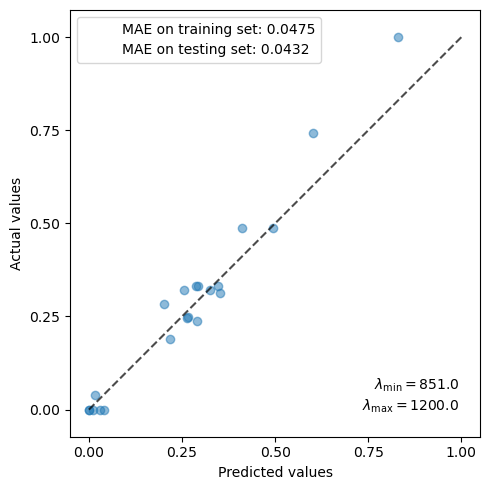

In [38]:
c_viable_models, c_bestmodel_container, c_y_best, c_X_best = grid_search_dataset(
    mix_train,
    nwindows,
    cv_models,
    target_chem='cellulose',
#     test_data=mix_test,
    test_data=None, # random selection of test data
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=0.01,
    metric=metric,
    metric_label=metric_label,
    x_bounds=None, # here is where you could restrict your spectral range
    plot_comparison=True,
    plot_comparison_savefile='./plots/axes_train'
)


In [39]:
c_bestmodel_container[0]
c_bestmodel_container[1]

array([ 851., 1200.])

### Get Hemicellulose model

In [40]:
import time

Running analysis splitting interval into 1 windows.
Running analysis on Ridge()
we have a new best model!
current score: 0.050466587920041404
Running analysis on PLSRegression()
we have a new best model!
current score: 0.046720275763769394
Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: Conv

Running analysis splitting interval into 5 windows.
Running analysis on Ridge()
Running analysis on PLSRegression()
Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: Conv

Running analysis splitting interval into 10 windows.
Running analysis on Ridge()
Running analysis on PLSRegression()
Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: Conv

Running analysis splitting interval into 50 windows.
Running analysis on Ridge()
Running analysis on PLSRegression()


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py", line 660, in fit
    super().fit(X, Y)
  File "/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.

Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
we have a new best model!
current score: 0.03933910505638601
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


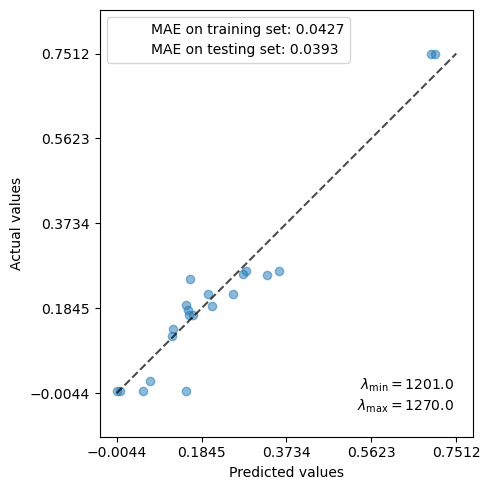

-159.90321683883667


In [41]:
start = time.time()
h_viable_models, h_bestmodel_container, h_y_best, h_X_best = grid_search_dataset(
    mix_train,
    nwindows,
    cv_models,
    target_chem='hemicellulose',
#     test_data=mix_test,
    test_data=None, # random selection of test data
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=0.01,
    metric=metric,
    metric_label=metric_label,
    x_bounds=None, # here is where you could restrict your spectral range
    plot_comparison=True,
    plot_comparison_savefile='./plots/axes_train'
)
end = time.time()
print(start-end)

### Get Lignin model

Running analysis splitting interval into 1 windows.
Running analysis on Ridge()
we have a new best model!
current score: 0.028222436334641894
Running analysis on PLSRegression()
Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Running analysis splitting interval into 5 windows.
Running analysis on Ridge()
Running analysis on PLSRegression()
Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: Conv

Running analysis splitting interval into 10 windows.
Running analysis on Ridge()
Running analysis on PLSRegression()
Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: Conv

Running analysis splitting interval into 50 windows.
Running analysis on Ridge()
Running analysis on PLSRegression()


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py", line 660, in fit
    super().fit(X, Y)
  File "/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.

Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


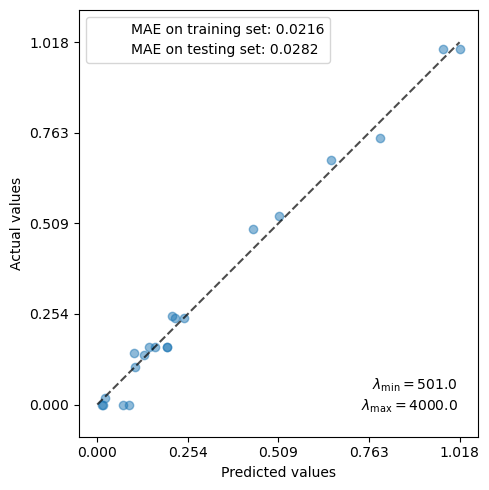

159.53355717658997


In [42]:
start = time.time()
l_viable_models, l_bestmodel_container, l_y_best, l_X_best = grid_search_dataset(
    mix_train,
    nwindows,
    cv_models,
    target_chem='lignin',
#     test_data=mix_test,
    test_data=None, # should be None if you want random selection of test data
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=0.01,
    metric=metric,
    metric_label=metric_label,
    x_bounds=None, # here is where you could restrict your spectral range
    plot_comparison=True,
    plot_comparison_savefile='./plots/axes_train'
)
end = time.time()
print(end-start)

### Get rot model

Running analysis splitting interval into 1 windows.
Running analysis on Ridge()
we have a new best model!
current score: 0.056378528320993354
Running analysis on PLSRegression()
we have a new best model!
current score: 0.04986964964851236
Running analysis on DecisionTreeRegressor()
we have a new best model!
current score: 0.02307809523809524
Running analysis on KernelRidge()
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: Conv

Running analysis splitting interval into 5 windows.
Running analysis on Ridge()
Running analysis on PLSRegression()
Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Running analysis splitting interval into 10 windows.
Running analysis on Ridge()
Running analysis on PLSRegression()
Running analysis on DecisionTreeRegressor()
we have a new best model!
current score: 0.022825521629840563
Running analysis on KernelRidge()
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: Conv

Running analysis splitting interval into 50 windows.
Running analysis on Ridge()
Running analysis on PLSRegression()


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py", line 660, in fit
    super().fit(X, Y)
  File "/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.

Running analysis on DecisionTreeRegressor()
Running analysis on KernelRidge()
Running analysis on SVR()
Running analysis on KNeighborsRegressor()
Running analysis on MLPRegressor(max_iter=400, solver='lbfgs')


/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ianbillinge/miniconda3/envs/mcr/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: Conv

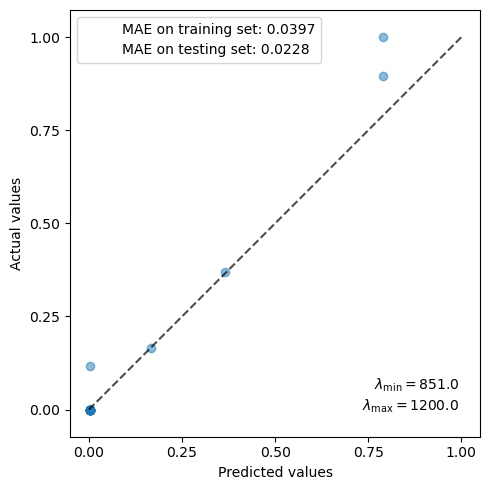

203.51328706741333


In [43]:
start = time.time()
r_viable_models, r_bestmodel_container, r_y_best, r_X_best = grid_search_dataset(
    mix_train,
    nwindows,
    cv_models,
    target_chem='rot',
#     test_data=mix_test,
    test_data=None, # should be None if you want random selection of test data
    tts_test_size=tts_size,
    tts_random_state=random_state,
    tolerance=0.01,
    metric=metric,
    metric_label=metric_label,
    x_bounds=None, # here is where you could restrict your spectral range
    plot_comparison=True,
    plot_comparison_savefile='./plots/axes_train'
)
end = time.time()
print(end-start)

In [44]:
def predict_on_test_csvs(fpath, bestmodel_container, regressand, target, sample_name=None, print_sample=False, printres=False):
    new_data = pd.read_csv(fpath, 
#                        names=['wavenumber', 'absorbance'], 
                       header=0, # it was reading in the first row as data and causing problems. So I just had it read the column namese from the first row
                       dtype='float')  
    
    # renamed for less typing, but you can absolutely get rid of these column names and just rename to your preference
    new_data = new_data.rename(columns={new_data.columns[0]:'x', new_data.columns[1]:'y'}) 

    # because if you look higher in the code, we are currently regressing on the derivative of the data
    # so I calculated the derivative here
    if regressand == 'a':
        new_data[regressand] = new_data['y']
    if regressand == 'da':
        new_data[regressand] = new_data['y'].diff() 
    elif regressand == 'd2a':
        new_data[regressand] = new_data['y'].diff(order=2)


    # get the wavelength window we care about and slice the data, only keeping that stuff
    window = bestmodel_container[1] 
    new_data = new_data.where(new_data['x'] > window[0]).where(new_data['x'] < window[1]).dropna()
    new_data_dy = np.array(new_data[regressand]).reshape(1,-1)

    predictor = bestmodel_container[0]
    prediction = predictor.predict(new_data_dy)
    
    # discard unwanted nested lists
    for i in prediction.shape:
        prediction = prediction[0] 
        
    if print_sample is True:
        print('Sample: {}'.format(sample_name))
        
    if printres:
        print("predicted composition {} {:1.3f}".format(target, prediction))
    return prediction

In [ ]:
predict_on_test_csvs(

### Save the trained models!

In [45]:
import pickle

predictors = [c_bestmodel_container[0], h_bestmodel_container[0], l_bestmodel_container[0], r_bestmodel_container[0]]
predictor_ranges = [c_bestmodel_container[1], h_bestmodel_container[1], l_bestmodel_container[1], r_bestmodel_container[1]]

predictor_files = ['cellulose_predictor.pkl', 'hemi_predictor.pkl', 'lignin_predictor.pkl', 'rot_predictor.pkl']
predictor_files = ['./trained_models/' + p for p in predictor_files]

for p, f in zip(predictors, predictor_files):
    with open(f, 'wb') as file:  
        pickle.dump(p, file)
        
predictor_metadata_files = [p.split('.pkl')[0] + '_meta.txt' for p in predictor_files] 
print(predictor_metadata_files)

for r, f in zip(predictor_ranges, predictor_metadata_files):
    with open(f, 'w') as file:
        for i in r:
            file.write(str(i) + '\n')


['./trained_models/cellulose_predictor_meta.txt', './trained_models/hemi_predictor_meta.txt', './trained_models/lignin_predictor_meta.txt', './trained_models/rot_predictor_meta.txt']
